# 1. Importing libs

In [ ]:
import os
import matplotlib.pyplot

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 2. Importing Tensorflow Dataset: MNIST

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


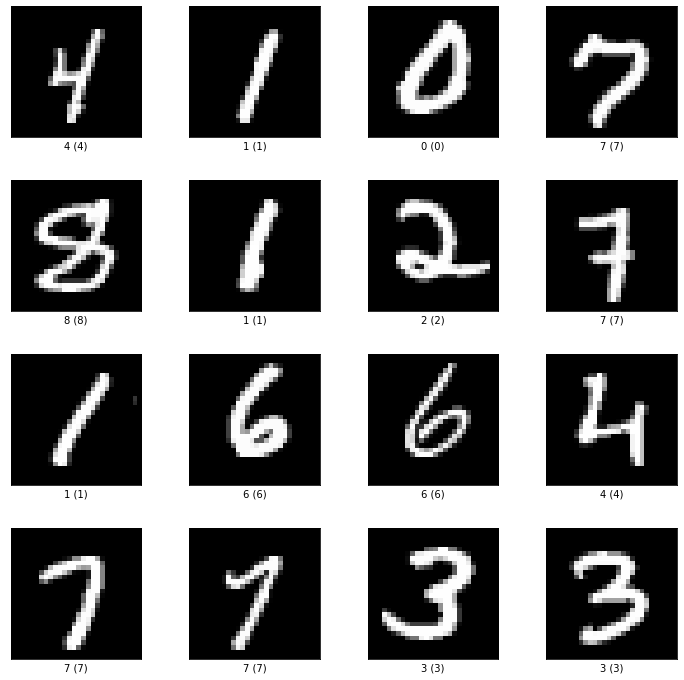

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)
print(ds_info)

# 3. Model Training (with MNIST dataset)

In [ ]:
def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

# Setup for test Dataset
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
469/469 - 25s - loss: 0.2592 - accuracy: 0.9278 - 25s/epoch - 53ms/step
Epoch 2/5
469/469 - 18s - loss: 0.0862 - accuracy: 0.9758 - 18s/epoch - 38ms/step
Epoch 3/5
469/469 - 18s - loss: 0.0597 - accuracy: 0.9825 - 18s/epoch - 39ms/step
Epoch 4/5
469/469 - 23s - loss: 0.0473 - accuracy: 0.9861 - 23s/epoch - 49ms/step
Epoch 5/5
469/469 - 21s - loss: 0.0380 - accuracy: 0.9885 - 21s/epoch - 45ms/step
79/79 [==============================] - 2s 26ms/step - loss: 0.0592 - accuracy: 0.9811


[0.059199217706918716, 0.9811000227928162]

# 4. Text Classification using IMDB Reviews Dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)

tokenizer = tfds.deprecated.text.Tokenizer()

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        '

In [ ]:
def build_vocabulary():
    """splits strings into tokens"""
    vocabulary = set()
    for text, _ in ds_train:
        vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
    return vocabulary


vocabulary = build_vocabulary()

# text encoding
# Reference: https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/TokenTextEncoder
encoder = tfds.deprecated.text.TokenTextEncoder(
    list(vocabulary), oov_token="<UNK>", lowercase=True, tokenizer=tokenizer
)

# Encodes text into a list of integers.
def my_enc(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label


def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(
        my_enc, inp=[text, label], Tout=(tf.int64, tf.int64)
    )

    # `tf.data.Datasets` work best if all components have a shape set
    #  so set the shapes manually:
    #  shape is set to None since text sequences can be of arbitrary length
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
# since sequences are of different lengths; they need to be padded to make equalize input lengths
ds_train = ds_train.padded_batch(32, padded_shapes=([None], ()))
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(encode_map_fn)
ds_test = ds_test.padded_batch(32, padded_shapes=([None], ()))

model = keras.Sequential(
    [
        layers.Masking(mask_value=0), # values are padded with zero
        layers.Embedding(input_dim=len(vocabulary) + 2, output_dim=100),
        # BATCH_SIZE x 1000 -> BATCH_SIZE x 1000 x 32
        layers.GlobalAveragePooling1D(),
        # BATCH_SIZE x 32
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1), # <<0 negative sentiment >>0 positive sentiment
    ]
)

model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1),
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=15, verbose=2)
model.evaluate(ds_test)

Epoch 1/15
782/782 - 89s - loss: 0.4799 - accuracy: 0.7124 - 89s/epoch - 114ms/step
Epoch 2/15
782/782 - 76s - loss: 0.2287 - accuracy: 0.9053 - 76s/epoch - 98ms/step
Epoch 3/15
782/782 - 75s - loss: 0.1620 - accuracy: 0.9389 - 75s/epoch - 96ms/step
Epoch 4/15
782/782 - 75s - loss: 0.1120 - accuracy: 0.9596 - 75s/epoch - 96ms/step
Epoch 5/15
782/782 - 75s - loss: 0.0828 - accuracy: 0.9727 - 75s/epoch - 96ms/step
Epoch 6/15
782/782 - 77s - loss: 0.0605 - accuracy: 0.9796 - 77s/epoch - 98ms/step
Epoch 7/15
782/782 - 78s - loss: 0.0417 - accuracy: 0.9874 - 78s/epoch - 100ms/step
Epoch 8/15
782/782 - 81s - loss: 0.0360 - accuracy: 0.9894 - 81s/epoch - 104ms/step
Epoch 9/15
782/782 - 77s - loss: 0.0277 - accuracy: 0.9916 - 77s/epoch - 98ms/step
Epoch 10/15
782/782 - 76s - loss: 0.0209 - accuracy: 0.9927 - 76s/epoch - 97ms/step
Epoch 11/15
782/782 - 75s - loss: 0.0210 - accuracy: 0.9926 - 75s/epoch - 96ms/step
Epoch 12/15
782/782 - 75s - loss: 0.0191 - accuracy: 0.9937 - 75s/epoch - 96ms/ste

[0.8550593256950378, 0.8590400218963623]